# Лабораторная работа № 5
## по дисциплине "Теория систем"
Чайкин В. К., P3324

Установка и импорт библиотек

In [1]:
!pip install numpy matplotlib control

  Obtaining dependency information for control from https://files.pythonhosted.org/packages/b2/9b/972af6f963631c10e98e35fe53a46f6f4ec1e2dd05c5d88f63f3c75c3d21/control-0.10.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/549.6 kB ? eta -:--:--
   - ------------------------------------- 20.5/549.6 kB 682.7 kB/s eta 0:00:01
   -- ------------------------------------ 41.0/549.6 kB 495.5 kB/s eta 0:00:02
   ----- --------------------------------- 81.9/549.6 kB 657.6 kB/s eta 0:00:01
   ------------- -------------------------- 184.3/549.6 kB 1.1 MB/s eta 0:00:01
   ------------------- -------------------- 266.2/549.6 kB 1.4 MB/s eta 0:00:01
   -------------------------- ------------- 368.6/549.6 kB 1.5 MB/s eta 0:00:01
   ------------------------------- -------- 430.1/549.6 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 549.6/549.6 kB 1.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import control.matlab as ctrl

Переходная функция

In [3]:
w = ctrl.tf([5, 1], [1, 5, 2])
w

TransferFunction(array([5, 1]), array([1, 5, 2]))

Переход к пространству состояний

In [4]:
print(w)
sys_stsp = ctrl.tf2ss(w)
sys_stsp

<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


   5 s + 1
-------------
s^2 + 5 s + 2



StateSpace(array([[-5., -2.],
       [ 1.,  0.]]), array([[1.],
       [0.]]), array([[5., 1.]]), array([[0.]]))

То же, но в виде отдельных матриц

In [5]:
a_matrix = sys_stsp.A
b_matrix = sys_stsp.B
c_matrix = sys_stsp.C
d_matrix = sys_stsp.D
print("A = ", a_matrix, 
      "B = ", b_matrix, 
      "C = ", c_matrix,
      "D = ", d_matrix,
      sep='\n'
      )

A = 
[[-5. -2.]
 [ 1.  0.]]
B = 
[[1.]
 [0.]]
C = 
[[5. 1.]]
D = 
[[0.]]


Полюса и нули переходной функции

In [6]:
print(f"Poles: {ctrl.pole(w)}")
print(f"Zeros: {ctrl.zero(w)}")

Poles: [-4.56155281+0.j -0.43844719+0.j]
Zeros: [-0.2+0.j]


Проверка стабильности, управляемости, наблюдаемости

In [7]:
eigvals, _ = np.linalg.eig(a_matrix)
print(f"Eigenvalues (continuous): {eigvals}")

# Controllability
ctrb = np.hstack([b_matrix, a_matrix @ b_matrix])
rank_ctrb = np.linalg.matrix_rank(ctrb)
print("Controllability rank:", rank_ctrb)

# Observability
obsv = np.vstack([c_matrix, c_matrix @ a_matrix])
rank_obsv = np.linalg.matrix_rank(obsv)
print("Observability rank:", rank_obsv)

Eigenvalues (continuous): [-4.56155281 -0.43844719]
Controllability rank: 2
Observability rank: 2


переходная характеристика

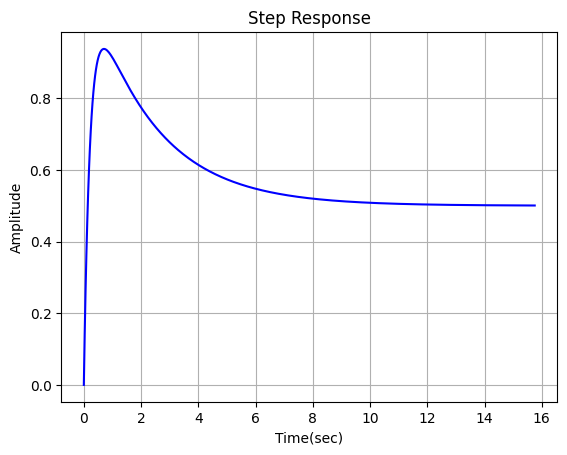

In [8]:
y, x = ctrl.step(w)
plt.plot(x, y, "b")
plt.title('Step Response')
plt.ylabel('Amplitude')
plt.xlabel('Time(sec)')
plt.grid(True)
plt.show()

импульсная характеристика

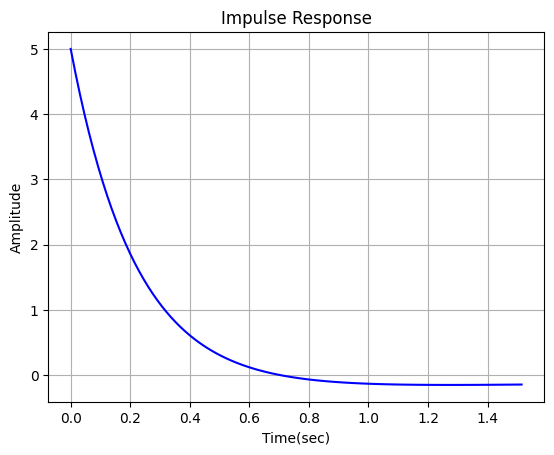

In [9]:
y, x = ctrl.impulse(w)
plt.plot(x, y, "b")
plt.title('Impulse Response')
plt.ylabel('Amplitude')
plt.xlabel('Time(sec)')
plt.grid(True)
plt.show()

диаграмма Боде

C:\Users\vadim\PycharmProjects\LabsAiSystems\venv\Lib\site-packages\control\freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


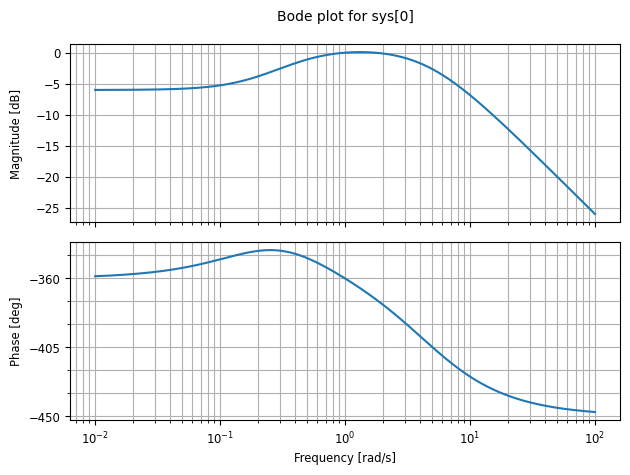

In [10]:
ctrl.bode(w, dB=True)
plt.plot()
plt.show()

диаграмма Найквиста

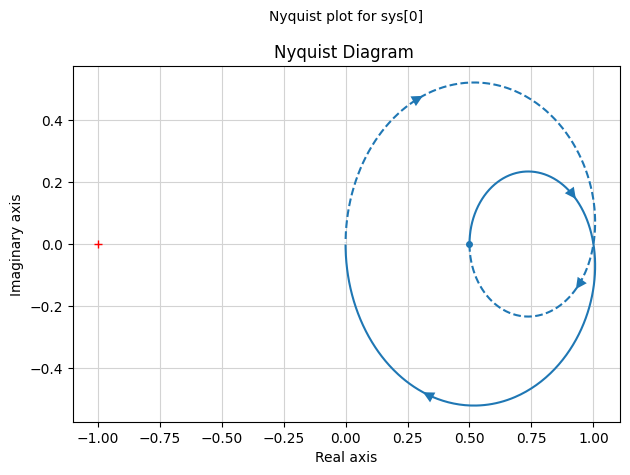

In [11]:
plt.title('Nyquist Diagram ')
plt.ylabel('Imaginary Axis')
plt.xlabel('Real Axis')
ctrl.nyquist(w)
plt.grid(True)
plt.plot()
plt.show()

фазовый портрет

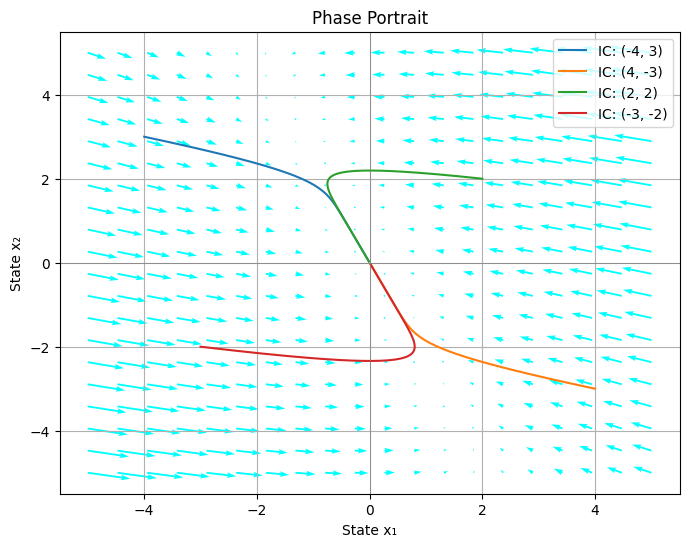

In [12]:
def phase_portrait():
      sys = ctrl.tf([5, 1], [1, 5, 2])
      sys_stsp = ctrl.tf2ss(sys)
      
      A = sys_stsp.A
      
      X1, X2 = np.meshgrid(np.linspace(-5, 5, 20), np.linspace(-5, 5, 20))
      
      U = A[0, 0] * X1 + A[0, 1] * X2
      V = A[1, 0] * X1 + A[1, 1] * X2
      
      plt.figure(figsize=(8, 6))
      plt.quiver(X1, X2, U, V, color='cyan')
      
      T = np.linspace(0, 10, 300)
      initial_conditions = [(-4, 3), (4, -3), (2, 2), (-3, -2)]
      for x0 in initial_conditions:
          T, yout, xout = ctl.forced_response(sys_stsp, T=T, U=0*T, X0=x0, return_x=True)
          plt.plot(xout[0], xout[1], label=f"IC: {x0}")
      
      plt.xlabel("State x₁")
      plt.ylabel("State x₂")
      plt.title("Phase Portrait")
      plt.axhline(0, color='grey', linewidth=0.5)
      plt.axvline(0, color='grey', linewidth=0.5)
      plt.legend()
      plt.grid()
      plt.show()

phase_portrait()

дискретизация

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from numpy.linalg import eig
import scipy.signal as sg

# Continuous-time system matrices
A = np.array([[0, 1], [-2, -5]])
B = np.array([[0], [1]])
C = np.array([[1, 5]])
D = np.array([[0]])

# Discretization interval
T = 0.1

# Compute discrete-time matrices
Ad = expm(A * T)

# Integral computation for Bd (numerical method)
n = 1000  # numerical precision
tau = np.linspace(0, T, n)
dtau = tau[1] - tau[0]
Bd = np.zeros((2, 1))

Bd = sum(expm(A * t_i) @ B * dtau for t_i in tau)

Cd = C.copy()

print("Ad = ", Ad)
print("Bd = ", Bd)
print("Cd = ", Cd)



Ad =  [[ 0.99149125  0.0784329 ]
 [-0.1568658   0.59932674]]
Bd =  [[0.0042583 ]
 [0.07851295]]
Cd =  [[1 5]]


проверка стабильности, построение графика

Stable [0.95710257 0.63371543]


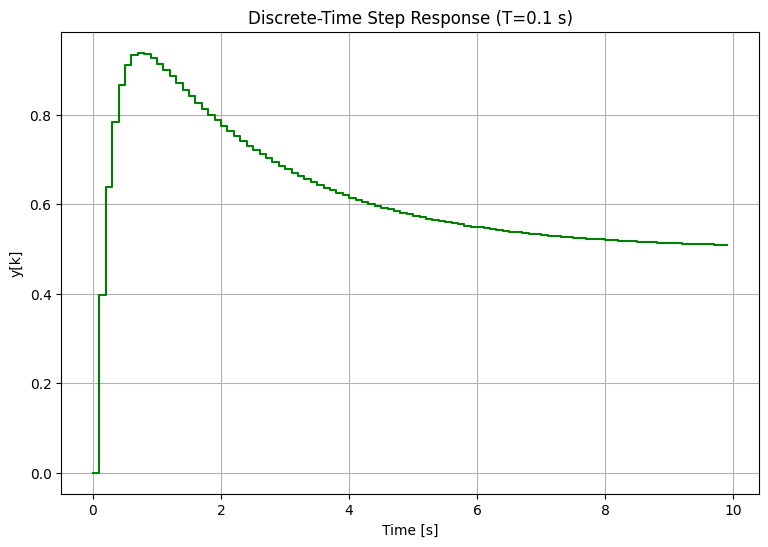

In [14]:
# Check stability
eigvals_d, _ = eig(Ad)
stable = np.all(np.abs(eigvals_d) < 1)

# Discrete-time step response
sys_d = sg.dlti(Ad, Bd, Cd, D, dt=T)
t_out, y_out = sg.dstep(sys_d, n=100)
y_out = np.squeeze(y_out)

print(("Stable" if stable else "Unstable"), eigvals_d)

# Plotting
plt.figure(figsize=(9, 6))
plt.step(t_out, y_out, where='post', color='green')
plt.xlabel('Time [s]')
plt.ylabel('y[k]')
plt.title('Discrete-Time Step Response (T=0.1 s)')
plt.grid(True)
plt.show()

